In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import all required libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Load the data and drop rows which have empty or None (for analysis) as summary

In [ ]:
df = pd.read_csv("./final_public_train.csv")

new_df = df[df["Summary"]!="None"]
new_df = new_df.dropna().reset_index(drop=True)
print("Number of rows dropped: ", len(df)-len(new_df))

Number of rows dropped:  1008


# Create counts plots for Customer and Type to show the counts distribution in each category

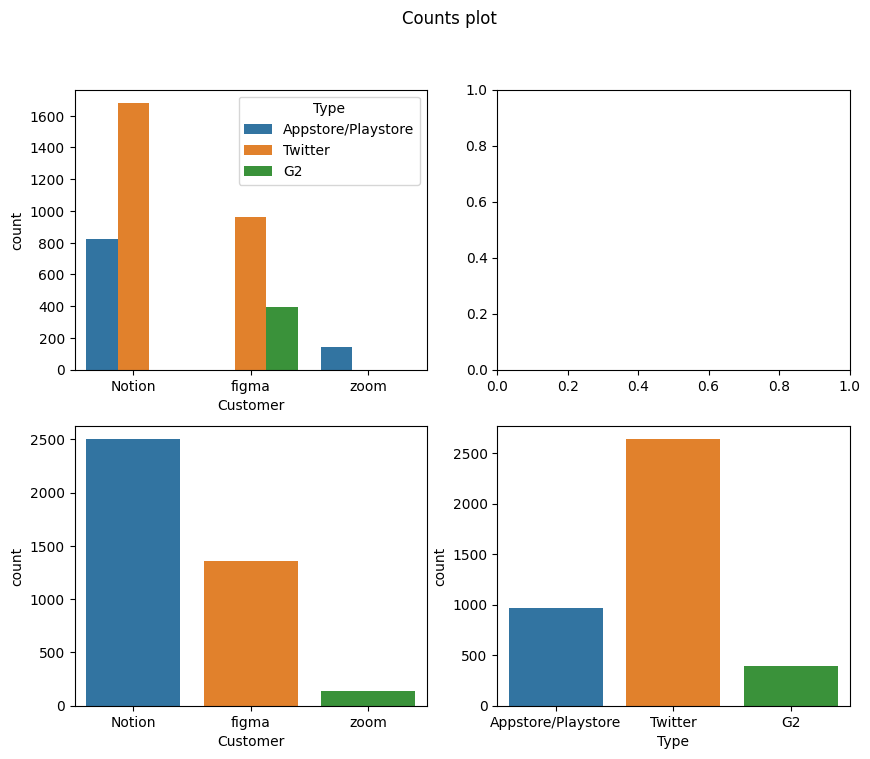

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(10, 8))
customer_order = list(new_df["Customer"].unique())
type_order = list(new_df["Type"].unique())

fig.suptitle('Counts plot')
count1 = sns.countplot(data=new_df, x='Customer', hue='Type', order = customer_order, ax=axes[0,0])
sns.countplot(data=new_df, x="Customer", order=customer_order, ax=axes[1,0])
sns.countplot(data=new_df, x="Type", order = type_order, ax=axes[1,1])
fig.show()

# Analysis
We can observe that:
1. Most of the user reviews are for Notion
2. Zoom has the least number of user reviews
3. User reviews for Notion are not collected from G2
4. User reviews for Figma are not collected from Playstore
5. User reviews for Zoom are only collected from Playstore

Counts plot comparison before and after removing empty rows

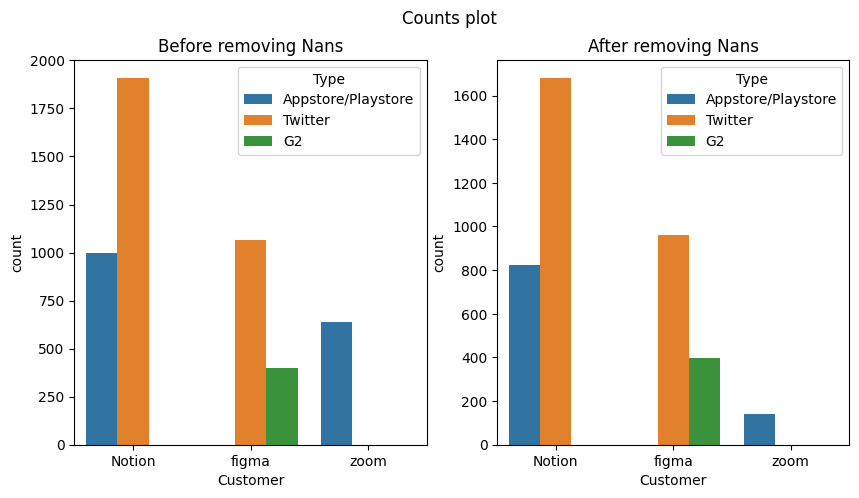

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
customer_order = list(df["Customer"].unique())
type_order = list(df["Type"].unique())
fig.suptitle('Counts plot')
count1 = sns.countplot(data=df, x='Customer', hue='Type', order = customer_order, ax=axes[0])
count1.set(title ='Before removing Nans')
count2 = sns.countplot(data=new_df, x='Customer', hue='Type', order = customer_order, ax=axes[1])
count2.set(title ='After removing Nans')
fig.show()

# Analysis

Zoom has the most number of rows with None or empty Summaries as shown below

In [ ]:
zoom_playstore_df = df[(df["Customer"]=="zoom") & (df["Type"]=="Appstore/Playstore")]
zoom_playstore_df.head()

,Customer,Type,Text,Summary
4368,zoom,Appstore/Playstore,User: Best app ever,User praises Zoom as the best app ever.
4369,zoom,Appstore/Playstore,User: Good,None
4370,zoom,Appstore/Playstore,User: Nay Lin Wati Khit,None
4371,zoom,Appstore/Playstore,User: Excellent,None
4372,zoom,Appstore/Playstore,User: Ok 👍,None


In [ ]:
new_df.groupby(["Customer", "Type"]).size()

Customer  Type              
Notion    Appstore/Playstore     823
          Twitter               1680
figma     G2                     398
          Twitter                959
zoom      Appstore/Playstore     141
dtype: int64

#Use semantic similarity to filter rows which are good summaries

In [ ]:
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('multi-qa-distilbert-dot-v1')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.8 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=1a1b330a4bf61122d1acbab76763fe0149885cfb6867c9c6790f8c9863a5b9d9
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
similarity_scores = []
for i, row in new_df.iterrows():
  text = row.Text
  summary = row.Summary
  text_embedding = model.encode(text)
  summary_embedding = model.encode(summary)
  cosine_sim = util.cos_sim(text_embedding, summary_embedding)[0][0].item()
  similarity_scores.append(cosine_sim)
  if i%200==0:
    print(i)


0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000


In [ ]:
# Create a new column "Similarity_scores"
new_df["Similarity_scores"] = similarity_scores
new_df.to_csv("./preprocessed_public_train_scores.csv", index=False)

# Create histograms and box plots of semantic similarity scores to show data from which platforms or which customers are labeled properly

Text(0.5, 1.0, 'Similarity Score by Customers')

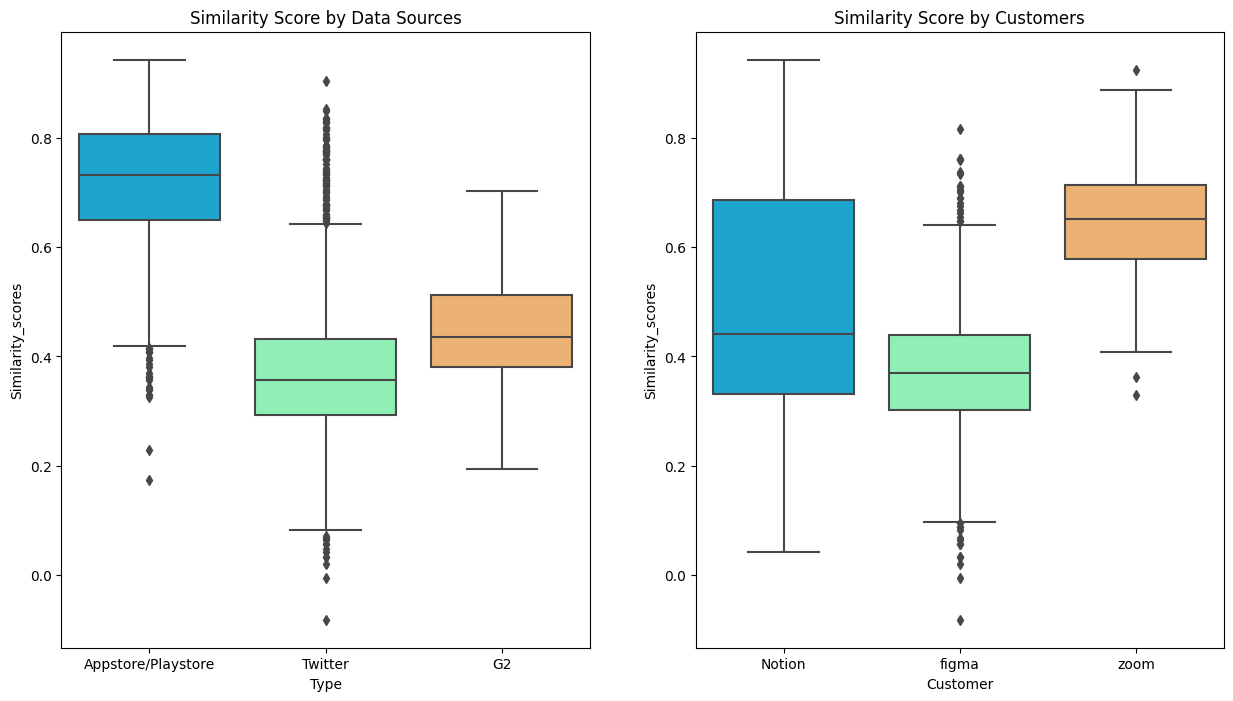

In [ ]:
rows = 1
columns = 2

fig = plt.figure(figsize=(15,8))
fig.add_subplot(rows, columns, 1)
sns.boxplot(x='Type',y='Similarity_scores',data=new_df, palette='rainbow')
plt.title("Similarity Score by Data Sources")

fig.add_subplot(rows, columns, 2)
sns.boxplot(x='Customer',y='Similarity_scores',data=new_df, palette='rainbow')
plt.title("Similarity Score by Customers")

Text(0.5, 1.0, 'Histogram of scores by Type')

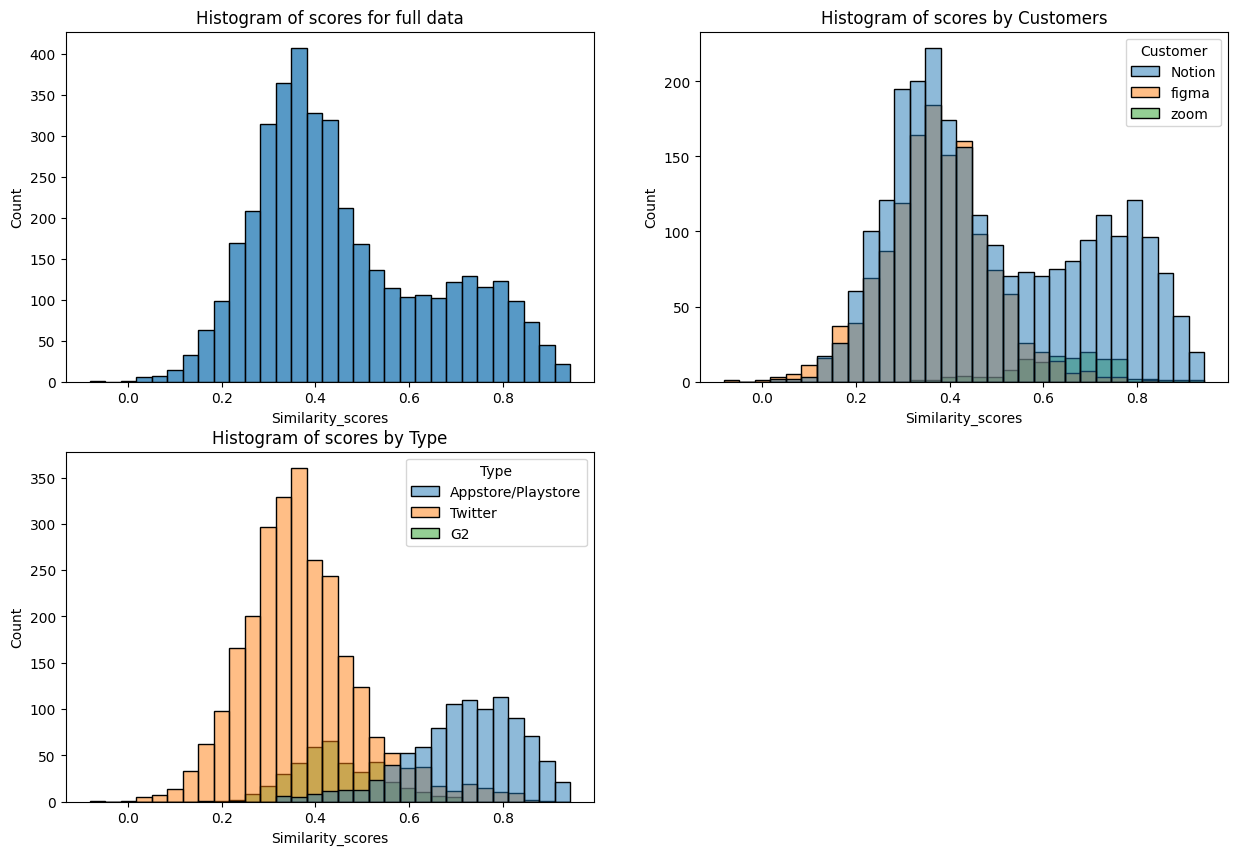

In [ ]:
rows = 2
columns = 2

fig = plt.figure(figsize=(15,10))
fig.add_subplot(rows, columns, 1)
sns.histplot(x='Similarity_scores', data=new_df)
plt.title("Histogram of scores for full data")

fig.add_subplot(rows, columns, 2)
sns.histplot(x='Similarity_scores',hue="Customer",data=new_df)
plt.title("Histogram of scores by Customers")

fig.add_subplot(rows, columns, 3)
sns.histplot(x='Similarity_scores',hue="Type",data=new_df)
plt.title("Histogram of scores by Type")

# Analysis

Using semantic similarity score between text and summary, the following observations cen be made:
1. User reviews from twitter has not been summarized properly.
2. Data from playstore have decent quality of summarized text
3. User reviews for figma has bad quality of summarized text

As shown below

In [ ]:
twitter_df = new_df[(new_df["Type"]=="Twitter") & (new_df["Similarity_scores"]<0.3)]
twitter_df.head(7)

,Customer,Type,Text,Summary,Similarity_scores
824,Notion,Twitter,User: We're excited to announce you can now wo...,User is excited about the new Notion for Teams...,0.240511
827,Notion,Twitter,User: Everyone's talking about #PLG. 📈\nLet's ...,User is excited about the new Notion app and i...,0.240790
840,Notion,Twitter,User: Does anyone know of any resources on sta...,User is excited about the new features in Noti...,0.194650
843,Notion,Twitter,User: I've loved using @NotionHQ AI... but the...,User is excited about the new features in Not...,0.224451
845,Notion,Twitter,User: Now have a second monitor that does noth...,User is using Notion for their personal proje...,0.136562
847,Notion,Twitter,User: I've loved using @NotionHQ AI... but the...,User is excited about the new features in Noti...,0.284126
853,Notion,Twitter,User: Hit that ❤️ if you use at least one of t...,User is excited about the new Notion for Team...,0.246523


In [ ]:
figma_df = new_df[(new_df["Customer"]=="figma") & (new_df["Similarity_scores"]<0.3)]
figma_df.head(7)

,Customer,Type,Text,Summary,Similarity_scores
2506,figma,Twitter,User: Does anyone have a contact at @figma?\nI...,User expresses frustration as their project ha...,0.237630
2507,figma,Twitter,User: ❤️ Love this! @tana_inc \nCheck out Tana...,User redesigned a project in Figma based on a...,0.237884
2511,figma,Twitter,User: Working on something sweet. \nThis might...,A user is seeking funding for their DonorsChoo...,0.168531
2512,figma,Twitter,User: Don't sleep on this update ya'll! 👀\nI c...,User is optimistic about AI's ability to ampl...,0.158510
2513,figma,Twitter,User: Does anyone have a contact at @figma?\nI...,User Fons Mans shared a tutorial thread on how...,0.252739
2516,figma,Twitter,User: Does anyone have a contact at @figma?\nI...,User Fons Mans shared a tutorial thread on how...,0.273924
2525,figma,Twitter,User: ❤️ Love this! @tana_inc \nCheck out Tana...,A user shared their DonorsChoose project link ...,0.224191


# Create word cloud after preprocessing review text to find important terms

In [ ]:
# Importing spacy
import spacy
import re
import string

# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

def preprocess_text(df, column):
  # convert text to lowercase
  df['cleaned'] = df[column].apply(lambda x: x.lower())
  # remove numbers and words containing digits from the reviews
  df['cleaned'] = df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))
  # remove punctuations from the reviews
  df['cleaned'] = df['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
  # Removing extra spaces
  df['cleaned'] = df['cleaned'].apply(lambda x: re.sub(' +',' ',x))
  # Lemmatization with stopwords removal
  df['Text_lemmatized'] = df['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))
  return df

df = preprocess_text(df, "Text")
new_df = preprocess_text(new_df, "Text")

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import  numpy as np
from PIL import Image
import requests

# Add 'user' and 'strictlink' to stopwords because every text
# starts with 'User: ' and most of the texts has 'STRICT_LINK' as a placeholder
stopwords = set(STOPWORDS)
stopwords.add("user")
stopwords.add("strictlink")


In [ ]:
def create_vocabulary_for_wordcloud(df, col_name, col_category):
  """Create a string of all the lemmatized words in a dataframe column
     filtered by category

     Args:
        df: pandas dataframe
        col_name: column name on which to filter
        col_category: category of the column to filter on

    Returns:
      comment_words (str): concatenated string of all lemmatized words
  """
  temp_df = df[df[col_name]==col_category]
  comment_words = ''
  for val in temp_df["Text_lemmatized"]:
      val = str(val)
      tokens = val.split()
      for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      comment_words += " ".join(tokens)+" "
  return comment_words


In [ ]:
# default image for word cloud
pic = np.array(Image.open(requests.get('http://www.clker.com/cliparts/O/i/x/Y/q/P/yellow-house-hi.png',stream=True).raw))
wordclouds = []

# create a list of wordclouds for all customer categories
for cust in customer_order:
  feedback = create_vocabulary_for_wordcloud(new_df, "Customer", cust)
  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords, mask = pic,
                min_font_size = 10).generate(feedback)
  wordclouds.append(wordcloud)

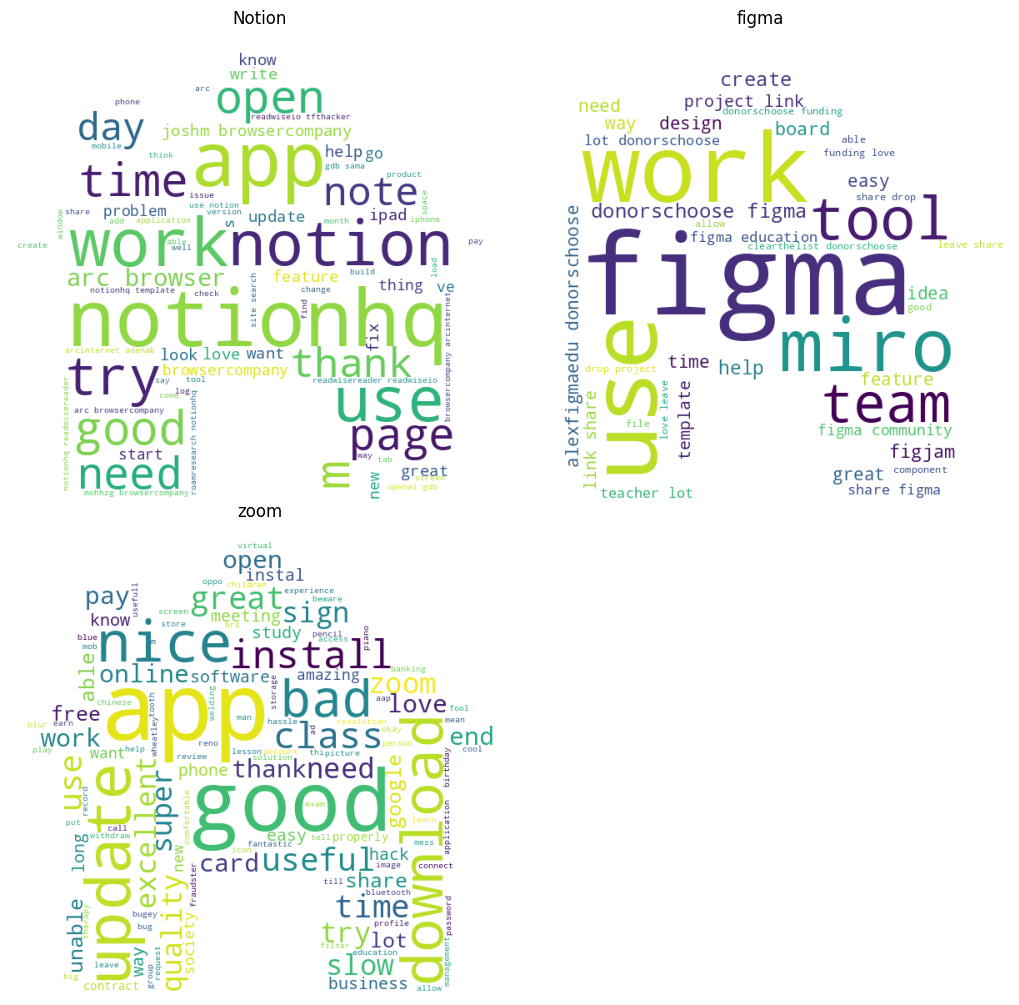

In [ ]:
# create figure
fig = plt.figure(figsize=(10, 10), facecolor = 'white', edgecolor='blue')

# setting values to rows and column variables
rows = 2
columns = 2

for i in range(len(customer_order)):
  # Adds a subplot at the 1st position
  fig.add_subplot(rows, columns, i+1)
  # showing image
  plt.imshow(wordclouds[i])
  plt.axis('off')
  plt.title(customer_order[i])
  plt.tight_layout(pad = 0)

plt.show()

# Analysis:

From the wordclouds, following observations can be made:
1. users use notion from browsers/ipads/iphone.
2. Users use Miro plugin for figma
3. Figma is easy to use and users use it to ideate, design or create features.
4. Many users have positive feedback for zoom

# Check sentiment of user reviews using TextBlob

In [ ]:
from textblob import TextBlob
new_df['polarity'] = new_df['Text_lemmatized'].apply(lambda x:TextBlob(x).sentiment.polarity)
# df['polarity'] = df['Text_lemmatized'].apply(lambda x:TextBlob(x).sentiment.polarity)

Text(0.5, 1.0, 'Sentiment Score by Customers')

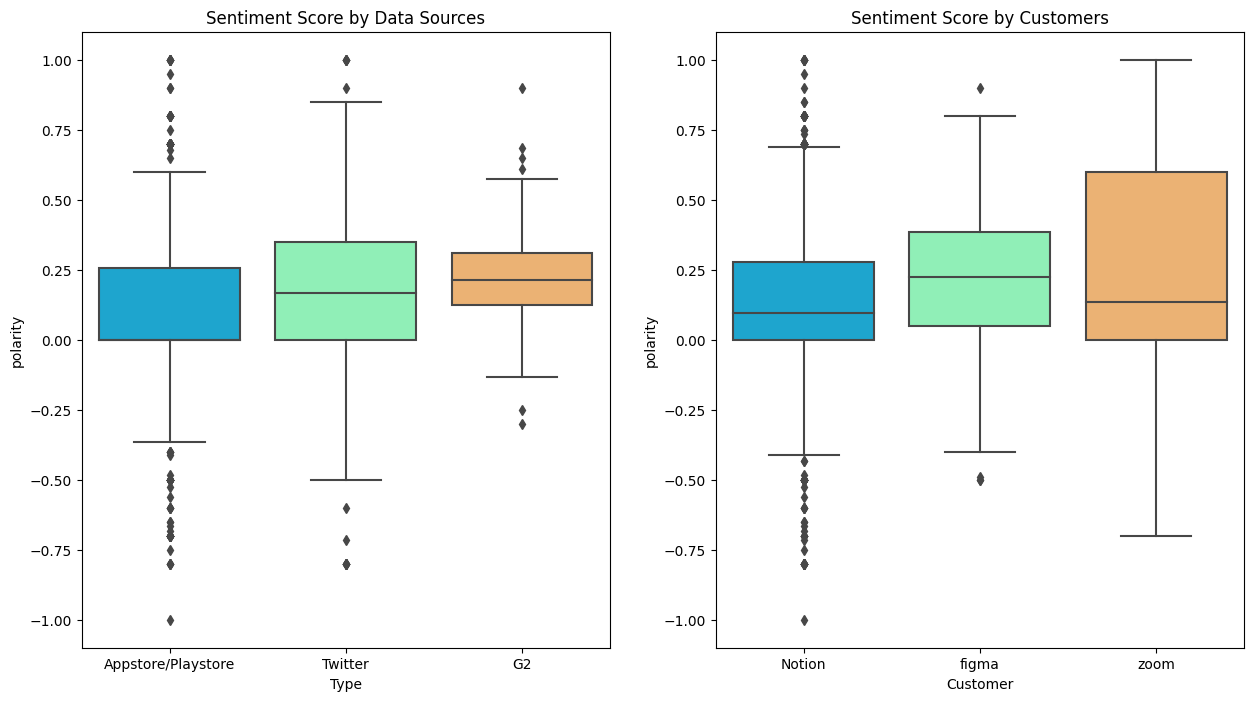

In [ ]:
rows = 1
columns = 2

fig = plt.figure(figsize=(15,8))
fig.add_subplot(rows, columns, 1)
sns.boxplot(x='Type',y='polarity',data=new_df, palette='rainbow')
plt.title("Sentiment Score by Data Sources")

fig.add_subplot(rows, columns, 2)
sns.boxplot(x='Customer',y='polarity',data=new_df, palette='rainbow')
plt.title("Sentiment Score by Customers")

# Analysis:

1. The same observations which has been made from wordcloud diagrams can be validated here as well such as.

  a. Zoom generally has a positive user feedback as compared to other customers

# Check word length distribution for different review platforms

Text(0.5, 1.0, 'Word Count by Data Sources')

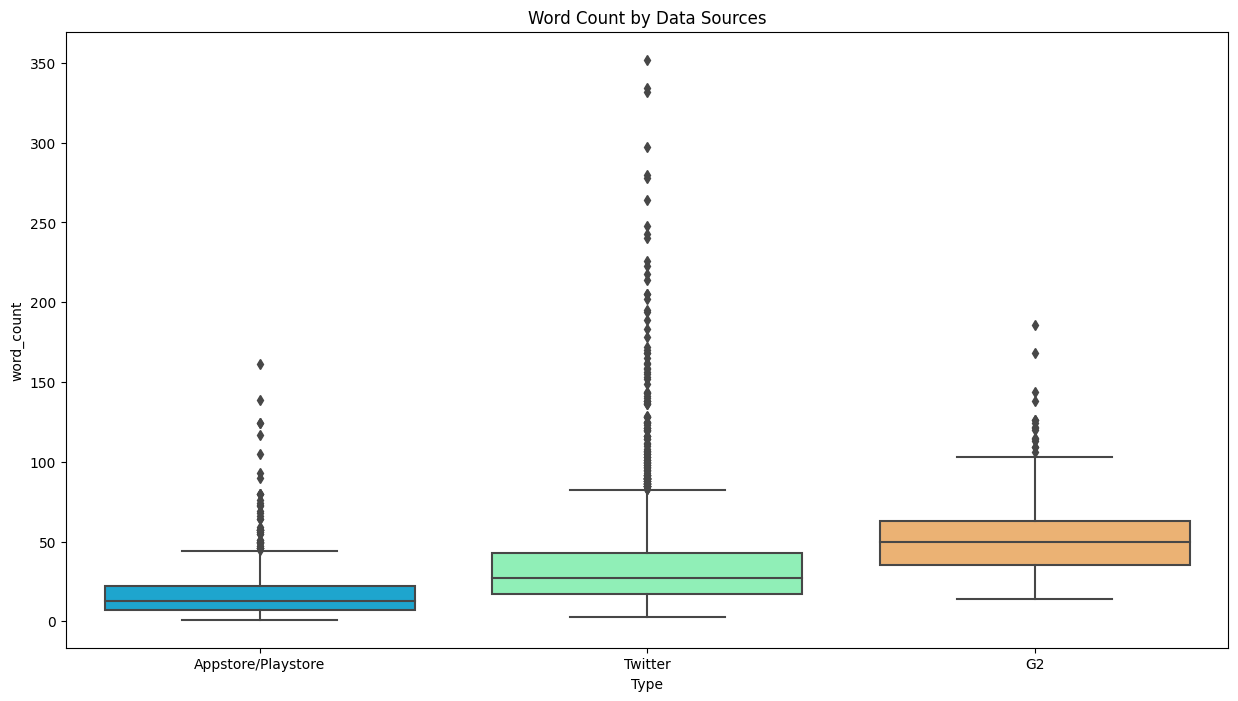

In [ ]:
new_df['word_count'] = new_df['Text_lemmatized'].apply(lambda x:len(x.split()))


rows = 1
columns = 1

fig = plt.figure(figsize=(15,8))
fig.add_subplot(rows, columns, 1)
sns.boxplot(x='Type',y='word_count',data=new_df, palette='rainbow')
plt.title("Word Count by Data Sources")

# Analysis:

1. G2 generally has longer text for user reviews on any product followed by Twitter and Playstore

# Check relation between word length and semantic similarity score

Text(0.5, 1.0, 'Relation between word_count and Similarity scores')

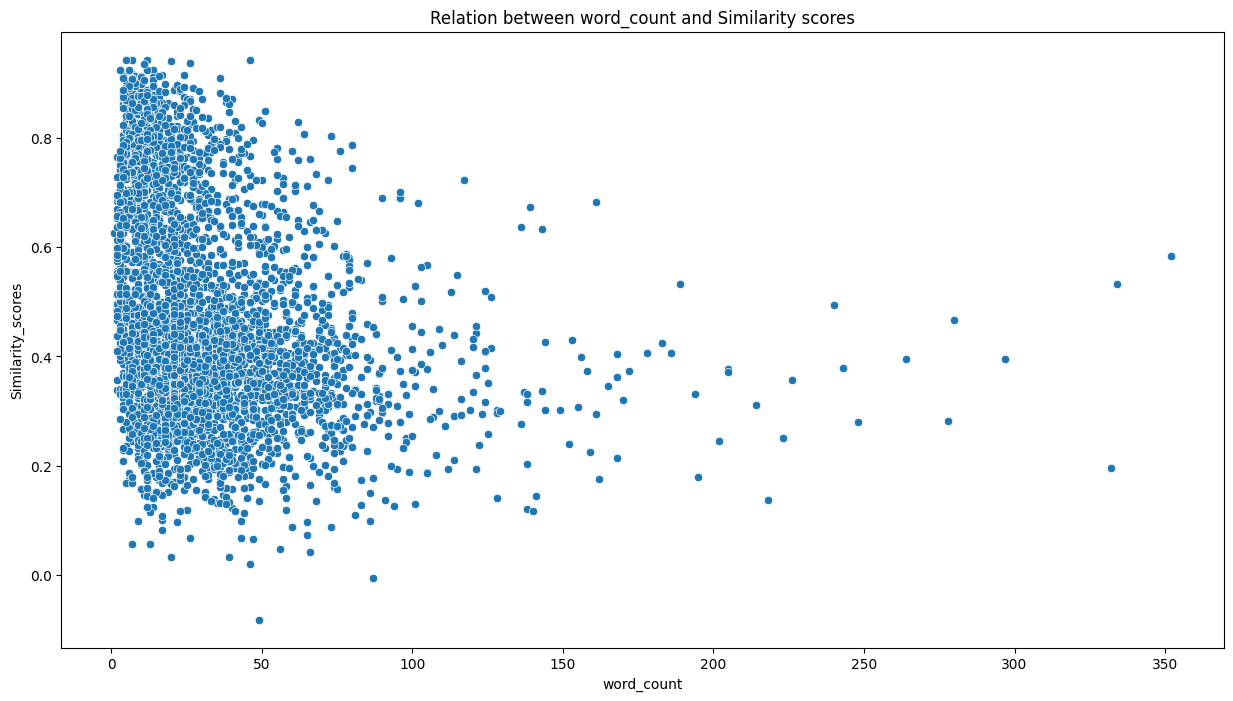

In [ ]:
rows = 1
columns = 1

fig = plt.figure(figsize=(15,8))
fig.add_subplot(rows, columns, 1)
sns.scatterplot(data=new_df, x='word_count', y='Similarity_scores')
plt.title("Relation between word_count and Similarity scores")

# Check relation between word length and sentiment score

Text(0.5, 1.0, 'Relation between word_count and sentiment scores')

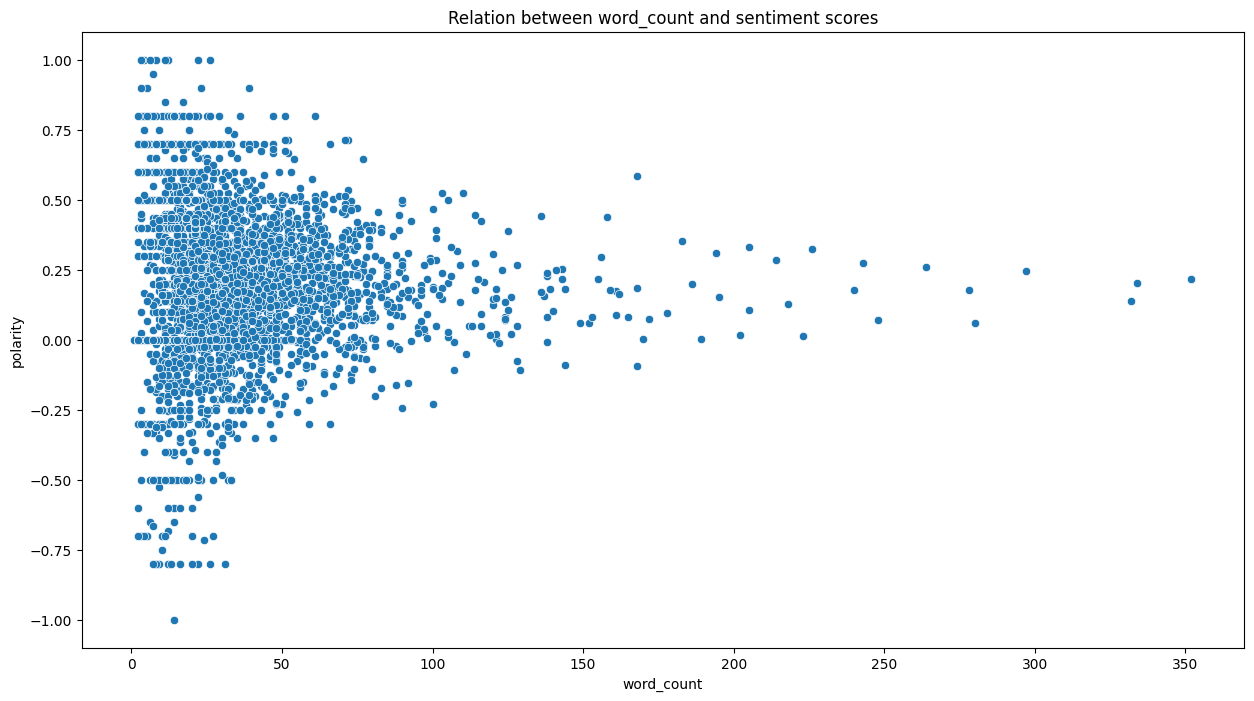

In [ ]:
rows = 1
columns = 1

fig = plt.figure(figsize=(15,8))
fig.add_subplot(rows, columns, 1)
sns.scatterplot(data=new_df, x='word_count', y='polarity')
plt.title("Relation between word_count and sentiment scores")

# Analysis:

1. From the above scatter plots it can be observed that there is no relation between:

  a. length of user review and quality of summary
  
  b. length of user review and sentiment of the review

# Compare word count distribution between data with "None" and not "None" as "Summary"

In [ ]:
df.to_csv("./user_review_scores_polarity_original.csv", index=False)
new_df.to_csv("./user_review_scores_polarity.csv", index=False)

In [ ]:
filtered_df = new_df[new_df["Similarity_scores"]>=0.5]
none_df = df[df["Summary"]=="None"]
merged_df = pd.concat([filtered_df, none_df], axis=0).sample(frac=1).reset_index(drop=True)


In [ ]:
# merged_df.tail()
merged_df.to_csv("./merged_none_filtered_data.csv", index=False)

Text(0.5, 1.0, 'Word Count for not None')

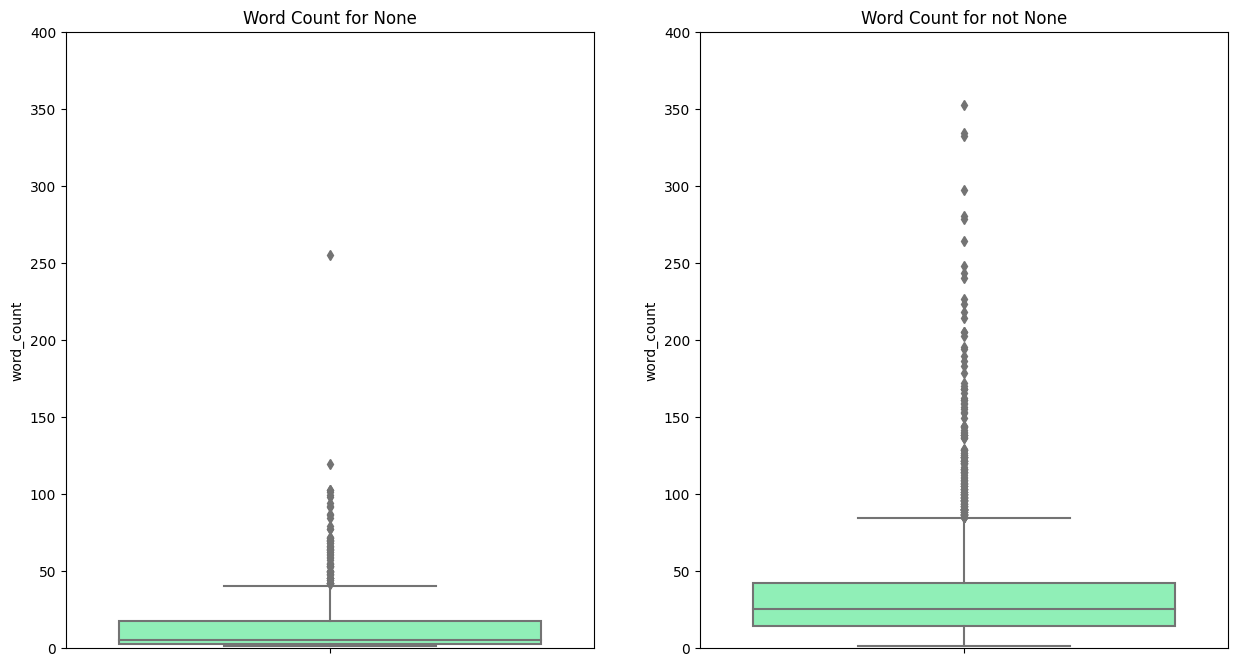

In [ ]:
rows = 1
columns = 2

fig = plt.figure(figsize=(15,8))
fig.add_subplot(rows, columns, 1)
plot1 = sns.boxplot(y='word_count',data=none_df, palette='rainbow')
plot1.set(ylim=(0, 400))
plt.title("Word Count for None")

fig.add_subplot(rows, columns, 2)
plot2 = sns.boxplot(y='word_count',data=new_df, palette='rainbow')
plot2.set(ylim=(0, 400))

plt.title("Word Count for not None")

# Analysis:

1. Shorter user reviews have None as "Summary" due to not sufficient content to summarize

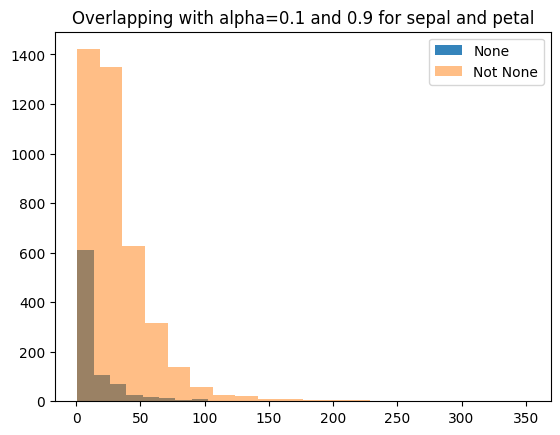

In [ ]:
plt.hist(none_df['word_count'],
         alpha=0.9,
         label='None', bins=20)

plt.hist(new_df['word_count'],
         alpha=0.5,
         label='Not None', bins=20)

plt.legend(loc='upper right')
plt.title('Overlapping with alpha=0.1 and 0.9 for sepal and petal')
plt.show()

# Analyze twitter data with low semantic similarity score

In [29]:
import pandas as pd
train_df = pd.read_csv("./train_raw.csv")

low_score_twitter_df = train_df[train_df["Similarity_scores"]<0.2]
low_score_twitter_df[["Text", "Summary", "Similarity_scores"]].loc[[613,211,222,238]]

,Text,Summary,Similarity_scores
613,User: Search @OpenAI's ChatGPT directly from C...,"User: I'm not sure if this is a bug or not, bu...",0.137625
211,User: To replicate or to do something differen...,Hiring a Data Scientist - Strategic Finance in...,0.187471
222,User: Question about buttons in @NotionHQ !\nW...,User is excited about the new Notion app and i...,0.181078
238,User: ChatGPT has more than 100 million users ...,User noticed that the FigJam marker looks good...,0.120484


# Analysis

1. Summary is generated from a Seq2Seq model which suffers from repetition problem.
2. Quality of Summary is not good as the generated summary is not even relevant to the text content.
3. Last message does not enough content to generate a good summary

# Stratify data into 3 groups for training
1. raw_data
2. data with semantic similarity > 0.5
2. data with semantic similarity > 0.6

In [ ]:
import os
os.mkdir("./train_filtered_50")
os.mkdir("./train_filtered_60")
os.mkdir("./train_raw")

In [ ]:
import pandas as pd
total_without_none_df = pd.read_csv("/content/total_without_none_df.csv")
# filtered_with_none_df = pd.read_csv("/content/merged_none_filtered_data.csv")

In [ ]:
# none_df = filtered_with_none_df[filtered_with_none_df["Summary"]=="None"].reset_index(drop=True)
# none_df.to_csv("./none_df.csv", index=False)
none_df = pd.read_csv("/content/none_df.csv")

In [ ]:
# sample_df["Appended_text"] = sample_df.apply(lambda row: row["Type"]+":"+row["Customer"]+": "+row["Text"], axis=1)

In [ ]:
def stratify_data_by_none(not_none_df, none_df, val_data_size=100):
  total_data_size = len(none_df) + len(not_none_df)
  train_data_size = total_data_size - val_data_size
  train_data_percent = train_data_size/total_data_size
  val_data_percent = val_data_size/total_data_size
  # percent_none = len(none_df)/total_data_size
  # percent_not_none = 1-percent_none

  train_data_none = none_df.sample(frac=train_data_percent)
  val_data_none = none_df.drop(train_data_none.index).reset_index(drop=True)
  train_data_none.reset_index(inplace=True, drop=True)

  train_data_not_none = not_none_df.sample(frac=train_data_percent)
  val_data_not_none = not_none_df.drop(train_data_not_none.index).reset_index(drop=True)
  train_data_not_none.reset_index(inplace=True, drop=True)

  train_data = pd.concat([train_data_none, train_data_not_none]).sample(frac=1).reset_index(drop=True)
  val_data = pd.concat([val_data_none, val_data_not_none]).sample(frac=1).reset_index(drop=True)

  train_data["Appended_text"] = train_data.apply(lambda row: row["Type"]+": "+row["Customer"]+": "+row["Text"], axis=1)
  train_data.drop(["cleaned", "Text_lemmatized"], axis=1, inplace=True)
  train_data = train_data.sample(frac=1, random_state=1).reset_index(drop=True)
  print(train_data["Similarity_scores"][:20])

  val_data["Appended_text"] = val_data.apply(lambda row: row["Type"]+": "+row["Customer"]+": "+row["Text"], axis=1)
  val_data.drop(["cleaned", "Text_lemmatized"], axis=1, inplace=True)
  val_data = val_data.sample(frac=1, random_state=1).reset_index(drop=True)
  print(val_data["Similarity_scores"][:20])

  return train_data, val_data


In [ ]:
train_raw_data, val_raw_data = stratify_data_by_none(total_without_none_df, none_df)
train_raw_data.to_csv("./train_raw/train_raw.csv", index=False)
val_raw_data.to_csv("./train_raw/val_raw.csv", index=False)

In [ ]:
filtered_50 = total_without_none_df[total_without_none_df["Similarity_scores"]>=0.5].reset_index(drop=True)

In [ ]:
train_filtered50_data, val_filtered50_data = stratify_data_by_none(filtered_50, none_df)
train_filtered50_data.to_csv("./train_filtered_50/train_filtered_50.csv", index=False)
val_filtered50_data.to_csv("./train_filtered_50/val_filtered_50.csv", index=False)

In [ ]:
filtered_60 = total_without_none_df[total_without_none_df["Similarity_scores"]>=0.6].reset_index(drop=True)

In [ ]:
train_filtered60_data, val_filtered60_data = stratify_data_by_none(filtered_60, none_df)
train_filtered60_data.to_csv("./train_filtered_60/train_filtered_60.csv", index=False)
val_filtered60_data.to_csv("./train_filtered_60/val_filtered_60.csv", index=False)

In [ ]:
print(len(train_filtered60_data[train_filtered60_data["Summary"]=="None"])/len(train_filtered60_data))
print(len(val_filtered60_data[val_filtered60_data["Summary"]=="None"])/len(val_filtered60_data))

0.4681712962962963
0.47


In [ ]:
print(len(train_filtered50_data[train_filtered50_data["Summary"]=="None"])/len(train_filtered50_data))
print(len(val_filtered50_data[val_filtered50_data["Summary"]=="None"])/len(val_filtered50_data))

0.3881235154394299
0.39


In [ ]:
import os
os.mkdir("./train_filtered_60")
os.mkdir("./train_filtered_50")